In [1]:
import sys
import seaborn as sns
from functools import partial
import matplotlib.pyplot as plt
import numpy as np
import jax
import jax.numpy as jnp
import jax.random as jrandom
import json
import haiku as hk

# === Config ===
BATCH_SIZE = 64
key = jax.random.PRNGKey(0)

In [2]:
sys.path.append("/Users/ratzenboe/Documents/work/projects/AstroSimformer/dev_jax_flow/core/")
from dev_jax_flow.core.build_transformer_model import build_transformer_model
from dev_jax_flow.core.trainer import TrainFlowModel
from train_interface.config_class import (TrainingConfig, SimformerConfig, TransformerConfig,
                                          DiffusionConfig, set_config_values)
from dev_jax_flow.core.euler_sampler import pure_batched_sampler

### 1) Data Generation


## Data Generation Functions

### **Theta Generation**
- $\theta_1 \sim \mathcal{N}(0, 3)$
- $\theta_2 \sim \mathcal{N}(0, 2)$

---

### **Data Features Calculation**
- **$x_1$** = $2 \cdot \sin(\theta_1) + 3 \cdot \cos(\theta_2) + \mathcal{N}(0, 0.5)$
- **$x_2$** = $0.1 \cdot \theta_1^2 + 0.5 \cdot |x_1| \cdot \mathcal{N}(0, 1)$
- **$x_3$** = $0.5 \cdot \theta_2 + 0.2 \cdot |x_2| \cdot \mathcal{N}(0, 1)$


In [3]:
def random_nan(data, key, nan_fraction=0.1):
    """Randomly set `nan_fraction` of values in the data to NaN."""
    # Calculate number of elements to replace with NaN
    total_elements = data.size
    nan_elements = int(total_elements * nan_fraction)
    # Generate random indices to replace with NaN
    key, subkey = jrandom.split(key)
    nan_indices = jrandom.choice(subkey, total_elements, shape=(nan_elements,), replace=False)
    # Create a mask of the same shape as the data
    nan_mask = jnp.zeros(total_elements, dtype=bool)
    nan_mask = nan_mask.at[nan_indices].set(True)
    # Reshape the mask to match the data's shape and apply NaNs
    nan_mask = nan_mask.reshape(data.shape)
    data_with_nans = jnp.where(nan_mask, jnp.nan, data)
    return data_with_nans


def normalize_data(data, epsilon=1e-8):
    """
    Normalize the data using (x - mean) / std with handling for NaN values.

    Args:
        data: Array of shape (n, features, 1)
        epsilon: Small constant to avoid division by zero

    Returns:
        normalized_data: Array of same shape as input, normalized per feature
        means: Mean values per feature
        stds: Standard deviation values per feature
    """
    # Reshape to (n, features) for easier processing
    data_reshaped = data.reshape(data.shape[0], -1)
    # Calculate mean ignoring NaN values
    means = jnp.nanmean(data_reshaped, axis=0)
    # Calculate std ignoring NaN values
    stds = jnp.nanstd(data_reshaped, axis=0)
    # Replace zero standard deviations with 1 to avoid division by zero
    stds = jnp.where(stds < epsilon, 1.0, stds)
    # Normalize the data
    normalized = (data_reshaped - means) / stds
    # Reshape back to original shape
    normalized = normalized.reshape(data.shape)
    return normalized, means, stds


def generate_data(key, n):
    key1, key2, key3 = jrandom.split(key,3)
    theta1 = jrandom.normal(key1, (n, 1))  * 3 # Some prior on a parameter
    x1 = 2*jnp.sin(theta1) + jrandom.normal(key2, (n, 1)) * 0.5 # Some data generated from the parameter
    x2 = 0.1*theta1**2 + 0.5*jnp.abs(x1)*jrandom.normal(key3, (n, 1)) # Some data generated from the parameter
    return jnp.concatenate([theta1,x1, x2], axis=1).reshape(n, -1, 1)

def log_potential(theta1, x1, x2, sigma_x1: float=0.5, sigma_x2: float=0.5, mean_loc: float=0.0, mean_scale: float=3.0):
    log_prob_theta = jax.scipy.stats.norm.logpdf(theta1, mean_loc, mean_scale)
    if x1 is not None:
        log_prob_x1 = jax.scipy.stats.norm.logpdf(x1, 2*jnp.sin(theta1), sigma_x1)
    else:
        log_prob_x1 = 0
    if x2 is not None:
        log_prob_x2 = jax.scipy.stats.norm.logpdf(x2, 0.1*theta1**2,  sigma_x2*jnp.abs(x1))
    else:
        log_prob_x2 = 0

    return log_prob_theta + log_prob_x1 + log_prob_x2

def true_posterior(theta, x1=None, x2=None):
    potential_theta = partial(log_potential, x1=x1, x2=x2)
    potential_post = potential_theta(theta)
    potential_post = potential_post - potential_post.max()
    potential_post = jnp.exp(potential_post)
    potential_post = potential_post / jax.scipy.integrate.trapezoid(potential_post, x=theta)
    return potential_post

# this switch is to indicate if you want to work with the csv file or just simulated example data
error = 0.0
def generate_data_combined_normal(key, n):
    data = generate_data(key, n)
    data_with_nans = random_nan(data, key, error)
    # Normalize data
    normalized_data, means, stds = normalize_data(data_with_nans)
    return normalized_data, data, means, stds

# 2 Create Data for all tries

This just creates the data using the functions above

In [4]:
# important here amount of data does it change something ?
data, data_clean_no_norm, means, stds = generate_data_combined_normal(
    jrandom.PRNGKey(1), 2**14
)  # Shape: (n, nodes, dim) here dim = 1
#
data_clean = ((data_clean_no_norm.squeeze(-1) - means) / stds)[..., None]  # shape (n, nodes, 1)
# nodes max = how many data points
nodes_max = data.shape[1]
# creates id for notes ?
node_ids = jnp.arange(nodes_max)
print(data.shape, nodes_max)
# check if nan values are present
print(jnp.isnan(data).sum())
n_features = data.shape[1]
labels = [f"x{i+1}" for i in range(n_features)]  # Automatically generate labels

(16384, 3, 1) 3
0


# 3) Config part
This could be done much more smoothly, but I am too lazy to change that right now

In [5]:
# Initialize the dataclasses with zero or default values
simformer_config = SimformerConfig()
transformer_config = TransformerConfig()
training_config = TrainingConfig()
diffusion_config = DiffusionConfig()

# Define values to set for each config parameter for multiple configurations
with open('simformer_config.json', 'r') as f:
    config_set = json.load(f)

set_config_values(simformer_config, config_set["SimformerConfig"])
set_config_values(transformer_config, config_set["TransformerConfig"])
set_config_values(training_config, config_set["TrainingConfig"])
set_config_values(diffusion_config, config_set["DiffusionConfig"])

dim_value = simformer_config.dim_value
dim_id = simformer_config.dim_id
dim_condition = simformer_config.dim_condition

num_heads = transformer_config.num_heads
num_layers = transformer_config.num_layers
attn_size = transformer_config.attn_size
widening_factor = transformer_config.widening_factor

epochs = training_config.epochs
time_steps = diffusion_config.time_steps

# Print or run the experiment for the current configuration
print(f"SimformerConfig: {simformer_config}")
print(f"TransformerConfig: {transformer_config}")
print(f"TrainingConfig: {training_config}")
print(f"DiffusionConfig: {diffusion_config}")
print("---" * 20)

SimformerConfig: SimformerConfig(dim_value=5, dim_id=5, dim_condition=3)
TransformerConfig: TransformerConfig(num_heads=2, num_layers=3, attn_size=10, widening_factor=3)
TrainingConfig: TrainingConfig(epochs=1000)
DiffusionConfig: DiffusionConfig(time_steps=512)
------------------------------------------------------------


# 4) Main Part of the Simformer

In [6]:
# This creates the SDE for noise in diffusion model
# data_clean = data.copy()
# impute NaNs with 0 -> this is done for because "Independent" cannot handle NaNs
# but these values will be masked during training so it will not affect the learning
# data_clean = jnp.nan_to_num(data_clean, 0.0)

# === Model parameters ===
model_init, model_fn = build_transformer_model(
    nodes_max=nodes_max,
    dim_value=dim_value,
    dim_id=dim_id,
    dim_condition=dim_condition,
    num_heads=num_heads,
    num_layers=num_layers,
    attn_size=attn_size,
    widening_factor=widening_factor,
    embed_time_dim=32
)

In [7]:
BATCH_SIZE = 2**9
BATCH_SIZE

512

In [8]:
# Use a small batch to initialize the model
x0 = jnp.zeros((BATCH_SIZE, nodes_max, 1))
t = jnp.ones((BATCH_SIZE, 1))
node_ids = jnp.tile(jnp.arange(nodes_max), (BATCH_SIZE, 1))
condition_mask = jnp.zeros_like(node_ids).astype(jnp.float32)
edge_mask = jnp.ones((BATCH_SIZE, nodes_max, nodes_max), dtype=bool)

params = model_init(key, t, x0, node_ids, condition_mask, edge_mask)

In [9]:
data.shape[0], BATCH_SIZE

(16384, 512)

In [10]:
train_model = TrainFlowModel(
    key=key,
    data=data,                        # shape (N, T, 1)
    model_fn=model_fn,                # Haiku-transformed apply fn
    params=params,
    nodes_max=data.shape[1],
    condition_groups=None,
    # Which variables to encode before passing to Flow matching algorithm
    batch_size=BATCH_SIZE,
    lr=1e-3,
    inner_train_loop_size=50,
    early_stopping_patience=30,
    model_check_point_dir=None, #"./checkpoints"  # optional
)

In [11]:
%%time
best_model = train_model.fit(epochs=50)

Epoch 1: loss = 1.989641
Epoch 2: loss = 1.686080
Epoch 3: loss = 1.570087
Epoch 4: loss = 1.523214
Epoch 5: loss = 1.503036
Epoch 6: loss = 1.478169
Epoch 7: loss = 1.474415
Epoch 8: loss = 1.441075
Epoch 9: loss = 1.469669
Epoch 10: loss = 1.457455
Epoch 11: loss = 1.452365
Epoch 12: loss = 1.441395
Epoch 13: loss = 1.447831
Epoch 14: loss = 1.436832
Epoch 15: loss = 1.442501
Epoch 16: loss = 1.421247
Epoch 17: loss = 1.430827
Epoch 18: loss = 1.434067
Epoch 19: loss = 1.435895
Epoch 20: loss = 1.410030
Epoch 21: loss = 1.430089
Epoch 22: loss = 1.441921
Epoch 23: loss = 1.428049
Epoch 24: loss = 1.413541
Epoch 25: loss = 1.434231
Epoch 26: loss = 1.409652
Epoch 27: loss = 1.428624
Epoch 28: loss = 1.426425
Epoch 29: loss = 1.424900
Epoch 30: loss = 1.422011
Epoch 31: loss = 1.413039
Epoch 32: loss = 1.435002
Epoch 33: loss = 1.393555
Epoch 34: loss = 1.413466
Epoch 35: loss = 1.397694
Epoch 36: loss = 1.398056
Epoch 37: loss = 1.424097
Epoch 38: loss = 1.405383
Epoch 39: loss = 1.40

# Sample from model

In [65]:
x_o = data_clean[80,:,0]
# test
condition_dim = jnp.array([0, 1])  # theta1
shape = (2**10,)
dim = data.shape[1]

# Normalize condition_value
condition_value = (jnp.asarray(x_o) - means) / stds  # shape (B, T)
condition_mask = jnp.zeros((dim,))  # shape (B, T)
condition_mask = condition_mask.at[condition_dim].set(1.0)  # shape (B, T)
edge_mask = jnp.ones((dim, dim), dtype=bool)  # shape (B, T, T)
node_ids_fit = jnp.arange(dim)

In [66]:
samples = pure_batched_sampler(
    train_model.model_fn,                         # static
    train_model.opt_params,                       # static
    key,
    shape,                               # shape tuple, not an integer
    condition_mask,                               # (B, T)
    condition_value,                              # (B, T)
    # jnp.tile(jnp.arange(dim)[None], (num_samples, 1)),  # (B, T)
    node_ids_fit,
    edge_mask,                                    # (B, T, T)
    100,                                           # steps (static)
    0.0,                                          # t0
    1.0,                                          # t1
)
samples_np = jax.device_get(samples)
samples_denorm = (samples_np * stds) + means  # shape (B, T, 1)

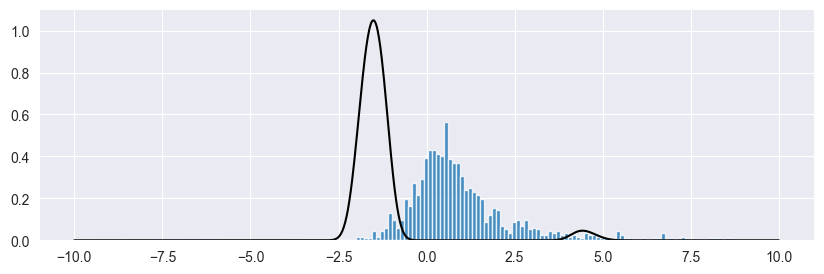

In [67]:
# Full conditional estimation
theta = jnp.linspace(-10, 10, 1000)
true_post = true_posterior(theta, x_o[condition_dim[0]], x_o[condition_dim[1]])

fig = plt.figure(figsize=(10, 3))
plt.plot(theta, true_post, color="k", label="True posterior")
plt.hist(
    samples_denorm[:, 2], bins=100, density=True,
    color="C0", alpha=0.8, label="Simformer samples"
)
plt.show()

In [35]:
# test
shape = (2**10,)
dim = data.shape[1]
# Normalize condition_value
condition_value = jnp.zeros((dim,))
condition_mask = jnp.zeros((dim,))  # shape (B, T)
edge_mask = jnp.ones((dim, dim), dtype=bool)  # shape (B, T, T)
node_ids_fit = jnp.arange(dim)

samples = pure_batched_sampler(
    train_model.model_fn,                         # static
    train_model.opt_params,                       # static
    key,
    shape,                               # shape tuple, not an integer
    condition_mask,                               # (B, T)
    condition_value,                              # (B, T)
    # jnp.tile(jnp.arange(dim)[None], (num_samples, 1)),  # (B, T)
    node_ids_fit,
    edge_mask,                                    # (B, T, T)
    100,                                          # steps (static)
    0.0,                                          # t0
    1.0,                                          # t1
)
samples_np = jax.device_get(samples)
samples_denorm = (samples_np * stds) + means  # shape (B, T, 1)

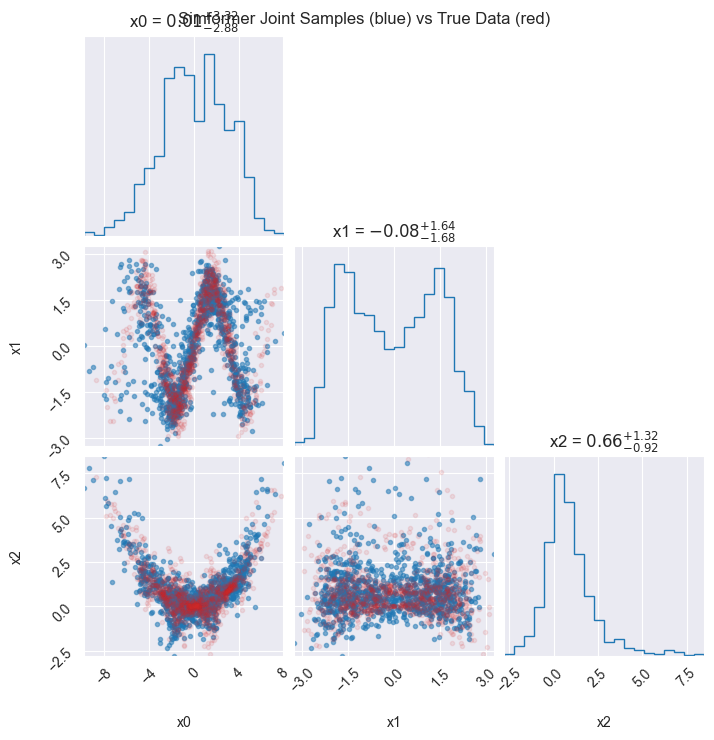

In [36]:
import matplotlib.pyplot as plt
import corner

labels = [f"x{i}" for i in range(nodes_max)]

# compare on a subset for visualization
samples_plot = samples_denorm[:1000]
real_plot = data_clean_no_norm[1000:2000, :, 0]  # shape (B, T)

# Combine samples and data
fig = corner.corner(
    np.asarray(samples_plot),
    color="C0",
    labels=labels,
    show_titles=True,
    title_fmt=".2f",
    truths=None,
    # contour_levels=[0.68, 0.95],
    # smooth=1.,
    plot_density=False,     # disable 2D histograms
    plot_contours=False,    # disable contour plots
    fill_contours=False,    # make sure it's off
)

corner.overplot_points(
    fig=fig,
    xs=np.asarray(samples_plot),
    color="tab:blue",
    alpha=0.5,
)

corner.overplot_points(
    fig=fig,
    xs=np.asarray(real_plot),
    color="tab:red",
    alpha=0.1,
)

plt.suptitle("Simformer Joint Samples (blue) vs True Data (red)")
plt.show()

# Marginalize over 1 and condition on another dimension

In [37]:
# Marginal estimation alone (if you leave out marginal consitstency in the loss, this will fail but the above will still work!)
shape = (2**10,)
# dim2keep = 1
node_ids_fit = jnp.array([0, 1], dtype=int)  # shape (B, T)
condition_mask = jnp.array([0, 1], dtype=int)
condition_value = (jnp.zeros((2,)) - means[node_ids_fit]) / stds[node_ids_fit]
# condition_value = jnp.zeros((2,))  # shape (B, T)
edge_mask = jnp.ones((2,2), dtype=bool)  # shape (B, T, T)

marginal_samples = pure_batched_sampler(
    train_model.model_fn,                         # static
    train_model.opt_params,                       # static
    key,
    shape,                               # shape tuple, not an integer
    condition_mask,                               # (B, T)
    condition_value,                              # (B, T)
    # jnp.tile(jnp.arange(dim)[None], (num_samples, 1)),  # (B, T)
    node_ids_fit,
    edge_mask,                                    # (B, T, T)
    64,                                           # steps (static)
    0.0,                                          # t0
    1.0,                                          # t1
)
marginal_samples_denorm = (marginal_samples * stds[node_ids_fit]) + means[node_ids_fit]

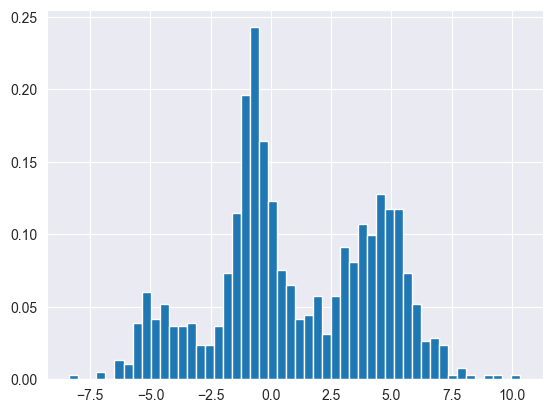

In [38]:
plt.hist(marginal_samples_denorm[:, 0], bins=50, density=True);

# Marginalize over 2 dims

In [39]:
# Marginal estimation alone (if you leave out marginal consitstency in the loss, this will fail but the above will still work!)
shape = (2**10,)
# dim2keep = 1
node_ids_fit = jnp.array([1], dtype=int)  # shape (B, T)
condition_mask = jnp.array([0], dtype=int)
condition_value = jnp.zeros((1,))
# condition_value = jnp.zeros((2,))  # shape (B, T)
edge_mask = jnp.ones((1,1), dtype=bool)  # shape (B, T, T)

marginal_samples = pure_batched_sampler(
    train_model.model_fn,                         # static
    train_model.opt_params,                       # static
    key,
    shape,                               # shape tuple, not an integer
    condition_mask,                               # (B, T)
    condition_value,                              # (B, T)
    # jnp.tile(jnp.arange(dim)[None], (num_samples, 1)),  # (B, T)
    node_ids_fit,
    edge_mask,                                    # (B, T, T)
    64,                                           # steps (static)
    0.0,                                          # t0
    1.0,                                          # t1
)
marginal_samples_denorm = (marginal_samples * stds[node_ids_fit]) + means[node_ids_fit]

<Axes: ylabel='Density'>

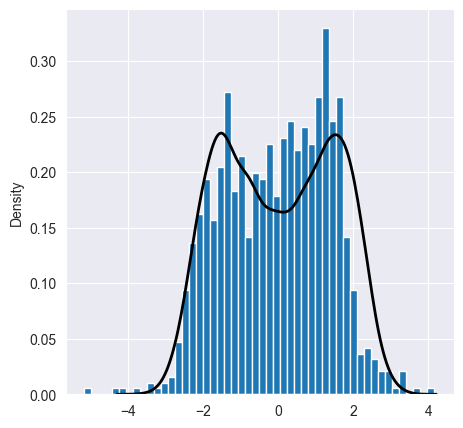

In [40]:
fig, ax = plt.subplots(1,1, figsize=(5,5))
_, bins, _ = ax.hist(marginal_samples_denorm, bins=50, density=True)
sns.kdeplot(data_clean_no_norm[:, node_ids_fit[0], 0], ax=ax, color="black", linewidth=2)

# Marginalization via edge mask

In [57]:
# Marginal estimation alone (if you leave out marginal consitstency in the loss, this will fail but the above will still work!)
shape = (2**10,)
# dim2keep = 1
all_node_ids = jnp.arange(3)
condition_mask = jnp.array([0, 0, 0], dtype=int)
condition_value = jnp.zeros((3,))
node_ids_fit = jnp.array([0, 1, 2], dtype=int)  # shape (B, T)
edge_mask = jnp.ones((3,3), dtype=bool)  # shape (B, T, T)
dim2keep = 2
marginal_ids = all_node_ids != dim2keep  # shape (B, T)
condition_value = condition_value.at[marginal_ids].set(1000.)  # shape (B, T)
# Set edge mask to False for all marginal nodes
edge_mask = edge_mask.at[marginal_ids[:, None] | marginal_ids[None, :]].set(False)

marginal_samples = pure_batched_sampler(
    train_model.model_fn,                         # static
    train_model.opt_params,                       # static
    key,
    shape,                               # shape tuple, not an integer
    condition_mask,                               # (B, T)
    condition_value,                              # (B, T)
    # jnp.tile(jnp.arange(dim)[None], (num_samples, 1)),  # (B, T)
    node_ids_fit,
    edge_mask,                                    # (B, T, T)
    64,                                           # steps (static)
    0.0,                                          # t0
    1.0,                                          # t1
)
marginal_samples_denorm = (jax.device_get(marginal_samples) * stds[node_ids_fit]) + means[node_ids_fit]

In [42]:
# marginal_samples_denorm

<Axes: ylabel='Density'>

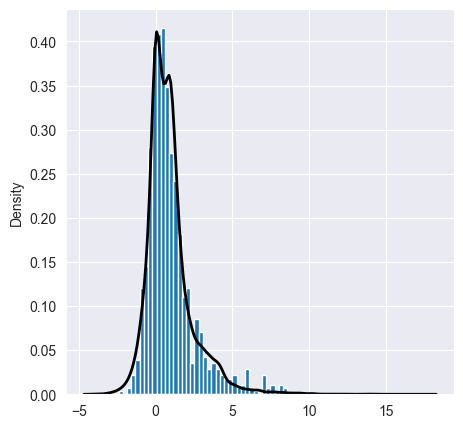

In [60]:
fig, ax = plt.subplots(1,1, figsize=(5,5))
dim2show = dim2keep
# dim2show = 1
_, bins, _ = ax.hist(marginal_samples_denorm[:, dim2show], bins=40, density=True)
sns.kdeplot(data_clean_no_norm[:, dim2show, 0], ax=ax, color="black", linewidth=2)

In [61]:
edge_mask

Array([[False, False, False],
       [False, False, False],
       [False, False,  True]], dtype=bool)